In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
# ==========================================================
# KAGGLE ML EXAM – CLEAN & CHRONOLOGICAL TEMPLATE
# Random Forest – (A) Binary Classification
# ==========================================================

# =====================
# 1. IMPORT LIBRARIES
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import warnings
warnings.filterwarnings('ignore')

# =====================
# 2. LOAD DATA
# =====================
train_df = pd.read_csv('/kaggle/input/mse-2-ai-201-b-ai-a/train.csv')
test_df  = pd.read_csv('/kaggle/input/mse-2-ai-201-b-ai-a/test.csv')

test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)

TARGET_COL = 'Class'   # CHANGE if needed

In [23]:
# =====================
# 3. EDA & VISUALIZATION (BEFORE CLEANING)
# =====================
display(train_df.info())
display(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           1669 non-null   float64
 1   PERIMETER      1559 non-null   float64
 2   MAJOR_AXIS     1599 non-null   float64
 3   MINOR_AXIS     1619 non-null   float64
 4   ECCENTRICITY   1714 non-null   float64
 5   EQDIASQ        1714 non-null   float64
 6   SOLIDITY       1729 non-null   float64
 7   CONVEX_AREA    1591 non-null   float64
 8   EXTENT         1631 non-null   float64
 9   ASPECT_RATIO   1581 non-null   float64
 10  ROUNDNESS      1730 non-null   float64
 11  COMPACTNESS    1542 non-null   float64
 12  SHAPEFACTOR_1  1587 non-null   float64
 13  SHAPEFACTOR_2  1709 non-null   float64
 14  SHAPEFACTOR_3  1706 non-null   float64
 15  SHAPEFACTOR_4  1698 non-null   float64
 16  Class          1688 non-null   object 
dtypes: float64(16), object(1)
memory usage: 242.4+ KB


None

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4
count,1669.000000,1559.000000,1599.000000,1619.000000,1714.000000,1714.000000,1729.000000,1591.000000,1631.000000,1581.000000,1730.000000,1542.000000,1587.000000,1709.000000,1706.000000,1698.000000
mean,80031.843020,1440.781173,446.300488,238.835295,0.837540,318.778931,0.938696,85341.970459,0.715778,1.888500,0.561369,0.714154,0.005698,0.003022,0.511885,0.954843
std,13258.365973,381.450829,32.359944,31.144061,0.051543,26.377185,0.051269,13278.092426,0.052413,0.247638,0.214684,0.045889,0.000829,0.000343,0.065281,0.051027
min,29808.000000,858.363000,320.344500,133.509600,0.609600,194.814600,0.588000,37935.000000,0.427200,1.261500,0.062800,0.476000,0.004000,0.002400,0.226600,0.620400
25%,71407.000000,1172.651500,427.050550,217.390700,0.813950,302.249750,0.918500,76656.000000,0.688650,1.720900,0.344800,0.682800,0.005100,0.002800,0.465825,0.942725
50%,79879.000000,1267.274000,448.425200,237.133600,0.847300,319.995500,0.952900,85709.000000,0.726800,1.883000,0.634300,0.712100,0.005600,0.003000,0.507050,0.972750
75%,89531.000000,1664.553450,467.475550,259.161650,0.873100,337.742775,0.976300,94426.500000,0.753750,2.054400,0.739875,0.743750,0.006100,0.003200,0.552375,0.987550
max,116282.000000,2748.856900,525.783800,336.686300,0.946000,384.779000,0.994800,123924.000000,0.820400,3.085800,0.933600,0.877900,0.013100,0.005300,0.770600,0.998700


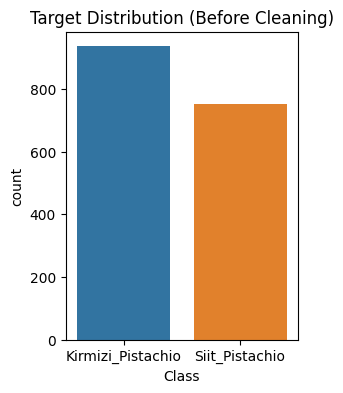

In [25]:
# Target distribution
plt.figure(figsize=(3,4))
sns.countplot(x=train_df[TARGET_COL])
plt.title('Target Distribution (Before Cleaning)')
plt.show()

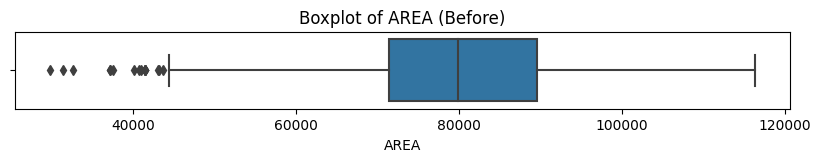

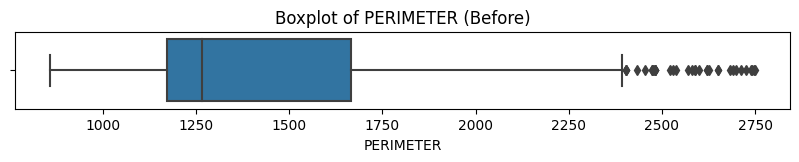

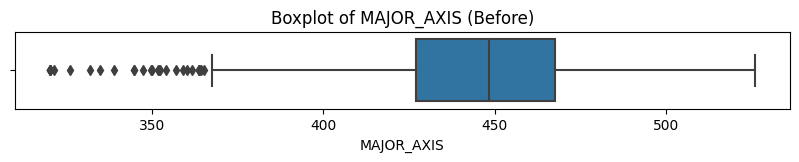

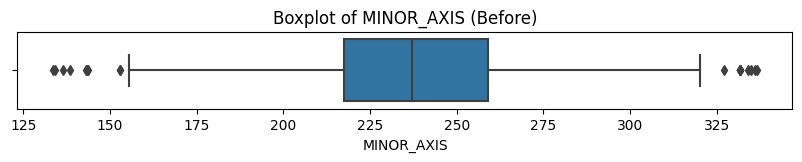

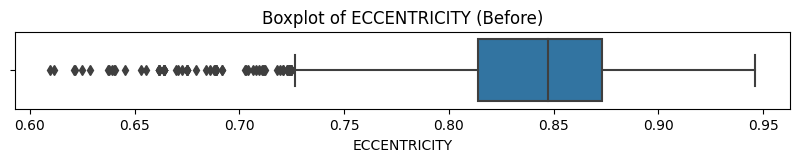

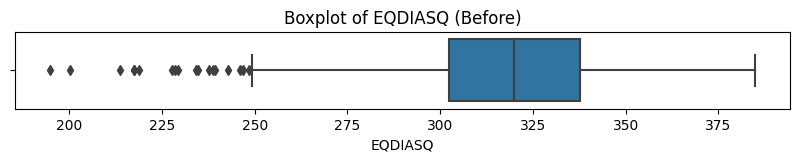

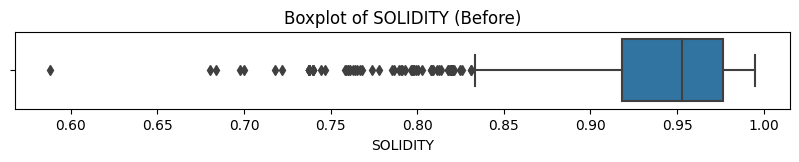

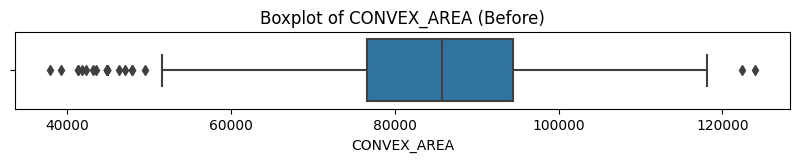

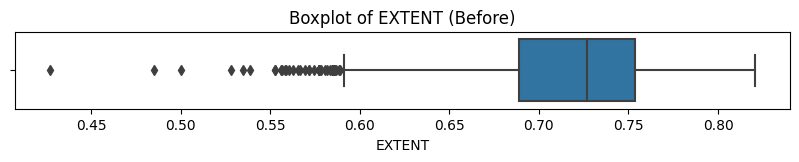

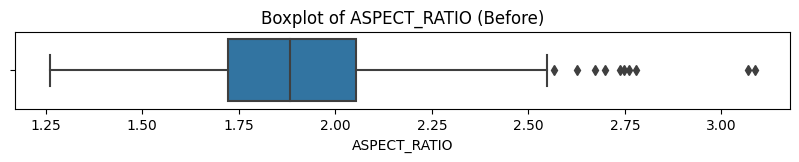

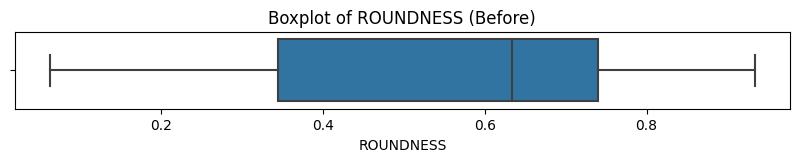

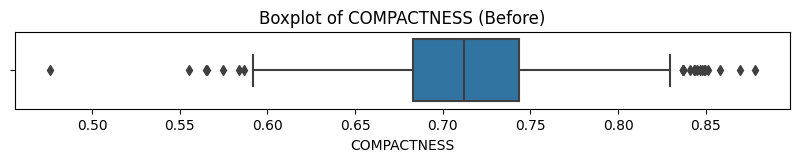

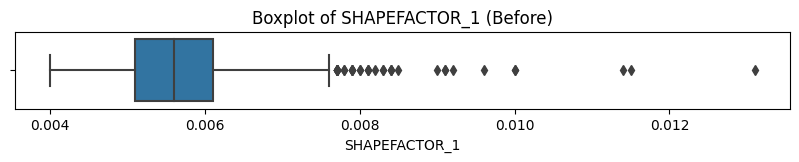

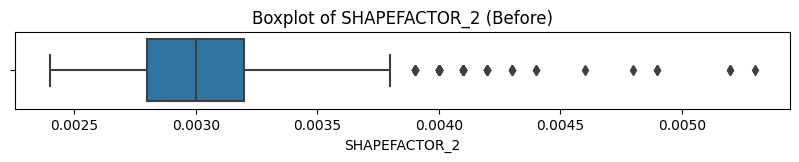

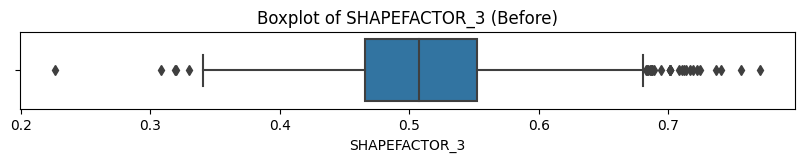

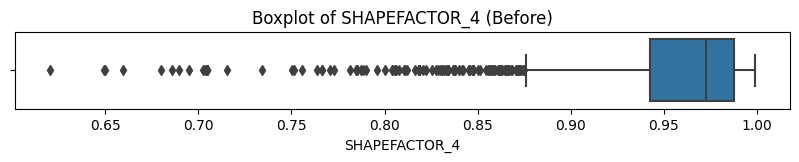

In [28]:
# Boxplots for outlier detection
num_cols = train_df.drop(TARGET_COL, axis=1).select_dtypes(include=np.number).columns

for col in num_cols:
    plt.figure(figsize=(10,1))
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col} (Before)')
    plt.show()

In [29]:
# =====================
# 4. HANDLE CATEGORICAL DATA
# =====================
label_encoders = {}
for col in train_df.select_dtypes(include='object').columns:
    if col != TARGET_COL:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))
        test_df[col]  = le.transform(test_df[col].astype(str))
        label_encoders[col] = le

if train_df[TARGET_COL].dtype == 'object':
    target_encoder = LabelEncoder()
    train_df[TARGET_COL] = target_encoder.fit_transform(train_df[TARGET_COL])

In [30]:
# =====================
# 5. HANDLE MISSING VALUES
# =====================
imputer = SimpleImputer(strategy='median')
train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
test_df[num_cols]  = imputer.transform(test_df[num_cols])

# =====================
# 6. REMOVE OUTLIERS (IQR METHOD)
# =====================
def iqr_clip(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower, upper)
    return df

train_df = iqr_clip(train_df, num_cols)

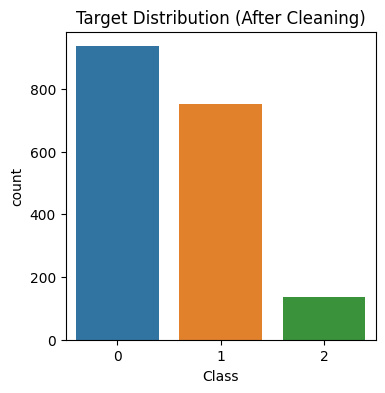

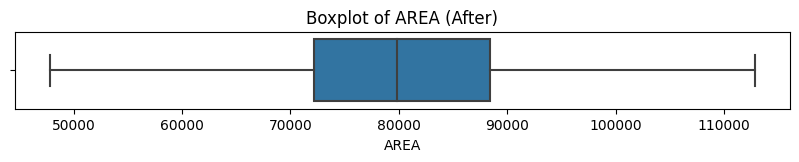

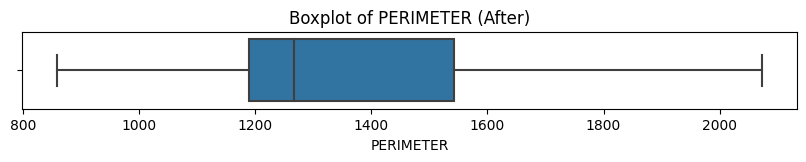

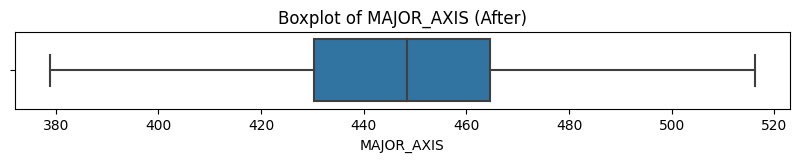

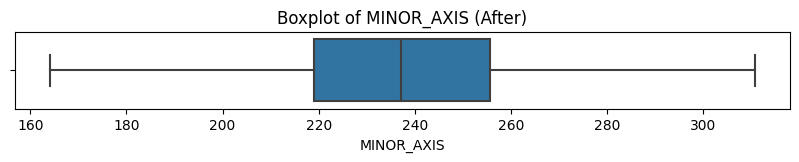

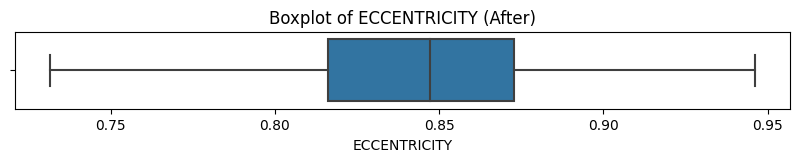

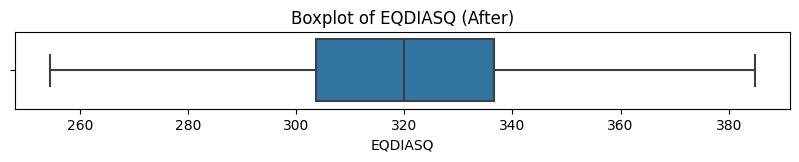

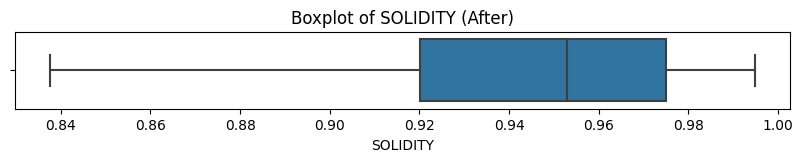

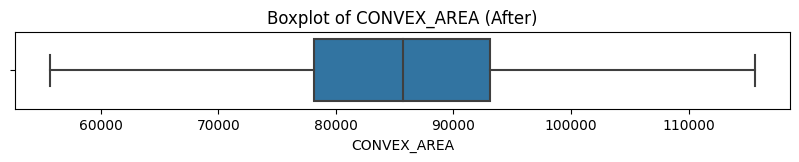

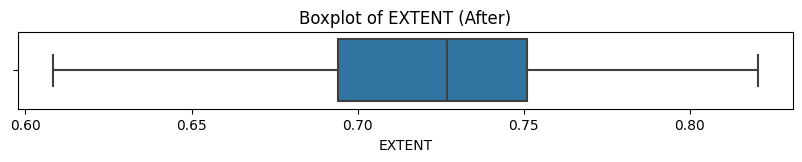

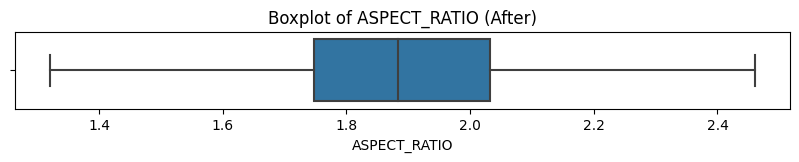

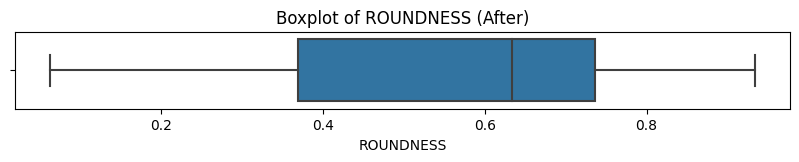

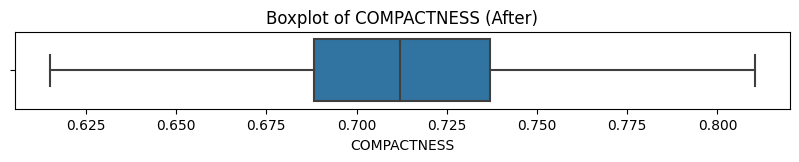

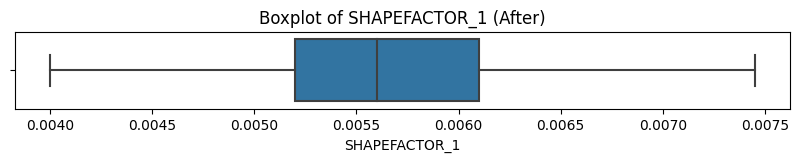

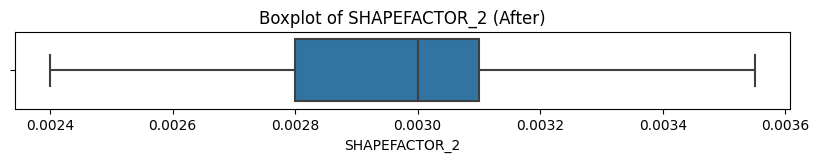

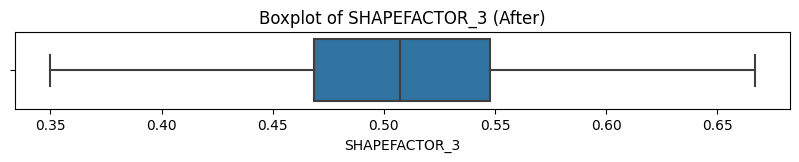

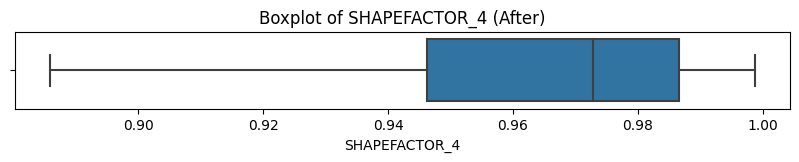

In [33]:
# =====================
# 7. VISUALIZATION (AFTER CLEANING)
# =====================
plt.figure(figsize=(4,4))
sns.countplot(x=train_df[TARGET_COL])
plt.title('Target Distribution (After Cleaning)')
plt.show()

for col in num_cols:
    plt.figure(figsize=(10, 1))
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col} (After)')
    plt.show()

In [34]:
# =====================
# 8. TRAIN–TEST SPLIT
# =====================
X = train_df.drop(TARGET_COL, axis=1)
y = train_df[TARGET_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================
# 9. SCALING (NOT REQUIRED FOR RANDOM FOREST)
# =====================
# Random Forest is tree-based → scaling NOT needed

In [35]:
# =====================
# 10. HYPERPARAMETER TUNING (GRIDSEARCH)
# =====================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


In [36]:
# =====================
# 11. MODEL EVALUATION
# =====================
y_pred = best_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

# =====================
# 12. SAVE MODEL
# =====================
joblib.dump(best_model, 'rf_binary_model.pkl')

# =====================
# 13. TEST PREDICTION & SUBMISSION
# =====================
test_preds = best_model.predict(test_df)


submission = pd.DataFrame({
    'id': test_ids,
    TARGET_COL: test_preds
})

submission.to_csv('submission_binary.csv', index=False)


print('submission_binary.csv created')

Accuracy: 0.8465753424657534
[[172  15   0]
 [ 19 132   0]
 [ 14   8   5]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       187
           1       0.85      0.87      0.86       151
           2       1.00      0.19      0.31        27

    accuracy                           0.85       365
   macro avg       0.90      0.66      0.68       365
weighted avg       0.86      0.85      0.83       365

submission_binary.csv created
